In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import sklearn.preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
CONV_FILE = 'results/cudnn/conv.csv'
GEMM_FILE = 'results/cudnn/gemm.csv'

In [2]:
def load_csv(file):
    return pd.read_csv(file)

In [3]:
def one_hot_encode_conv(df):
    precision = pd.get_dummies(df.precision)
    fwd_algo = pd.get_dummies(df.fwd_algo)
    df.drop(columns=['precision', 'fwd_algo'], inplace=True)
    df = pd.concat([df, precision, fwd_algo], axis=1)

    print(f'New encoded columns: {precision.columns, fwd_algo.columns}')
    return df

In [4]:
def one_hot_encode_gemm(df):
    precision = pd.get_dummies(df.precision)
    df.drop(columns=['precision'], inplace=True)
    df = pd.concat([df, precision], axis=1)

    print(f'New encoded columns: {precision.columns}')
    return df

In [5]:
def normalize(X, y):
    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(X))
    y = pd.Series(ss.fit_transform(np.array(y).reshape(-1,1))[:,0])
    return X, y

def prune_columns_conv(df):
    # Drop columns that only have one value (i.e. same number of threads per block across all architectures, etc)
    unique = df.nunique() == 1
    drop_idx = unique[unique == True].index.array
    df.drop(columns=drop_idx, inplace=True)

    drop_cols = ['sm_cap', 'cuda_version', 'h', 'f_h']
    df.drop(columns=drop_cols, inplace=True)

    print('Dropped columns: ', drop_idx, drop_cols)
    return df

In [6]:
def prune_columns_gemm(df):
    # Drop columns that only have one value (i.e. same number of threads per block across all architectures, etc)
    unique = df.nunique() == 1
    drop_idx = unique[unique == True].index.array
    df.drop(columns=drop_idx, inplace=True)

    drop_cols = ['sm_cap', 'cuda_version']
    df.drop(columns=drop_cols, inplace=True)

    print('Dropped columns: ', drop_idx, drop_cols)
    return df



In [39]:
df = load_csv(CONV_FILE)
df = prune_columns_conv(df)
df = one_hot_encode_conv(df)
print(df.info())
print(df.describe())

Dropped columns:  <PandasArray>
[                'total_const_mem',      'total_shared_mem_per_block',
         'total_num_reg_per_block',                       'warp_size',
           'max_threads_per_block',                 'gpu_sharing_mem',
            'host_page_locked_mem',                     'ecc_support',
              'unified_addressing',              'compute_preemption',
       'cooperative_kernel_launch', 'multi_device_cooperative_kernel']
Length: 12, dtype: object ['sm_cap', 'cuda_version', 'h', 'f_h']
New encoded columns: (Index(['float', 'half', 'int8'], dtype='object'), Index(['FFT', 'FFT_TILING', 'GEMM', 'IMPLICIT_GEMM', 'IMPLICIT_PRECOMP_GEMM',
       'WINOGRAD', 'WINOGRAD_NONFUSED'],
      dtype='object'))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52337 entries, 0 to 52336
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   w                      52337 non-null  int64 

array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'f_w'}>,
        <AxesSubplot:title={'center':'pad_w'}>],
       [<AxesSubplot:title={'center':'pad_h'}>,
        <AxesSubplot:title={'center':'stride_w'}>,
        <AxesSubplot:title={'center':'stride_h'}>,
        <AxesSubplot:title={'center':'fwd_time(usec)'}>,
        <AxesSubplot:title={'center':'pad_kernels'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>],
       [<AxesSubplot:title={'center':'cuda_cores'}>,
        <AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>,
        <AxesSubplot:title={'center':'l2_cache_size'}>,
        <AxesSubplot:title={'center':'max_threads_per_mp'}>],
       [<AxesSubplot:title={'center':'bandwidth_GBps'}>,
  

<Figure size 432x288 with 0 Axes>

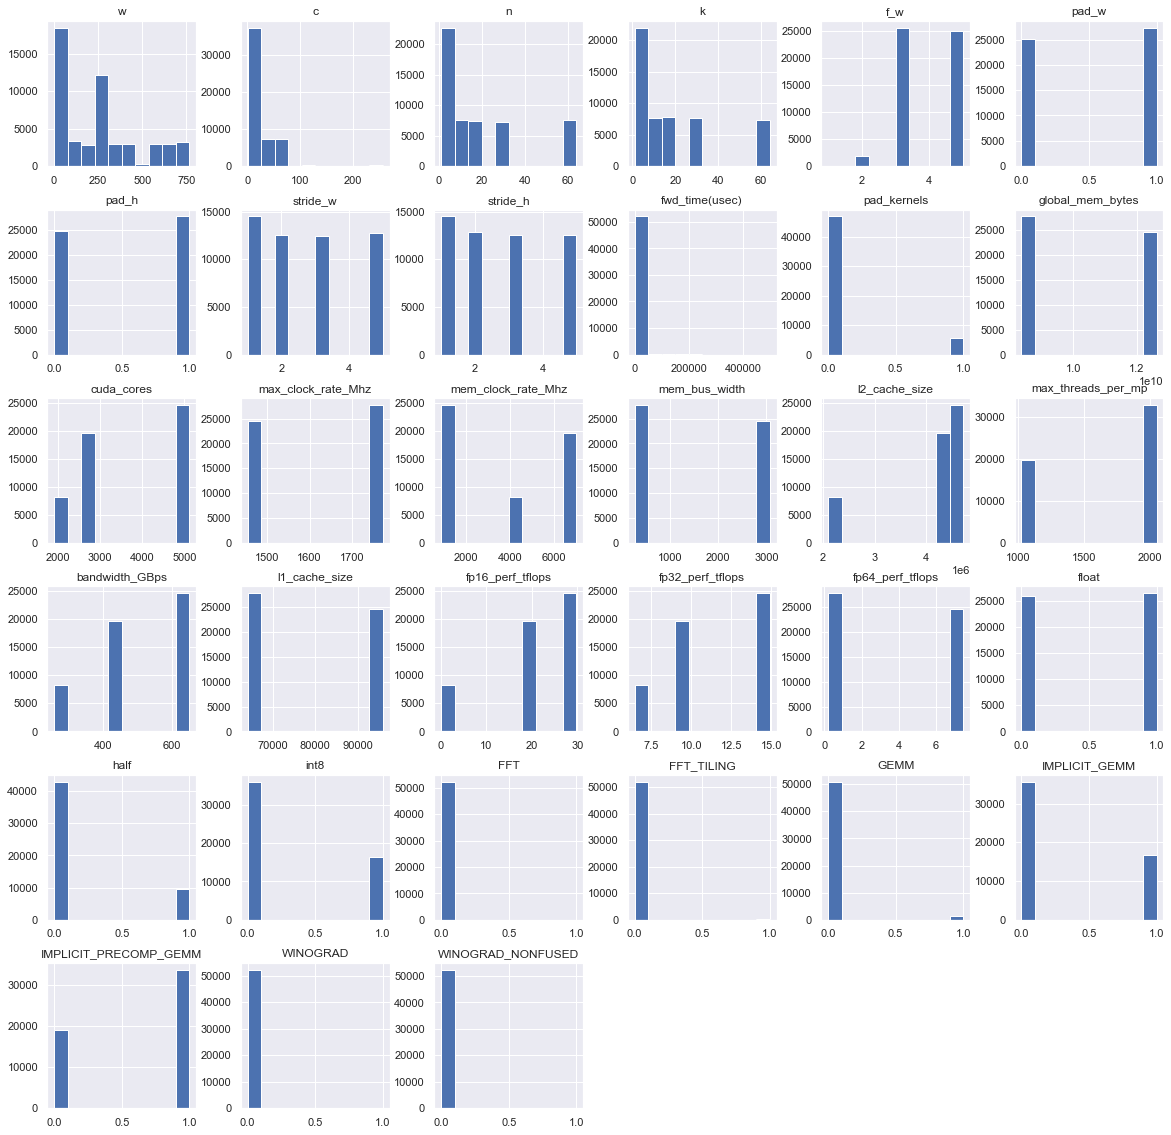

In [40]:
fig = plt.figure()
df.hist(figsize=(20,20))

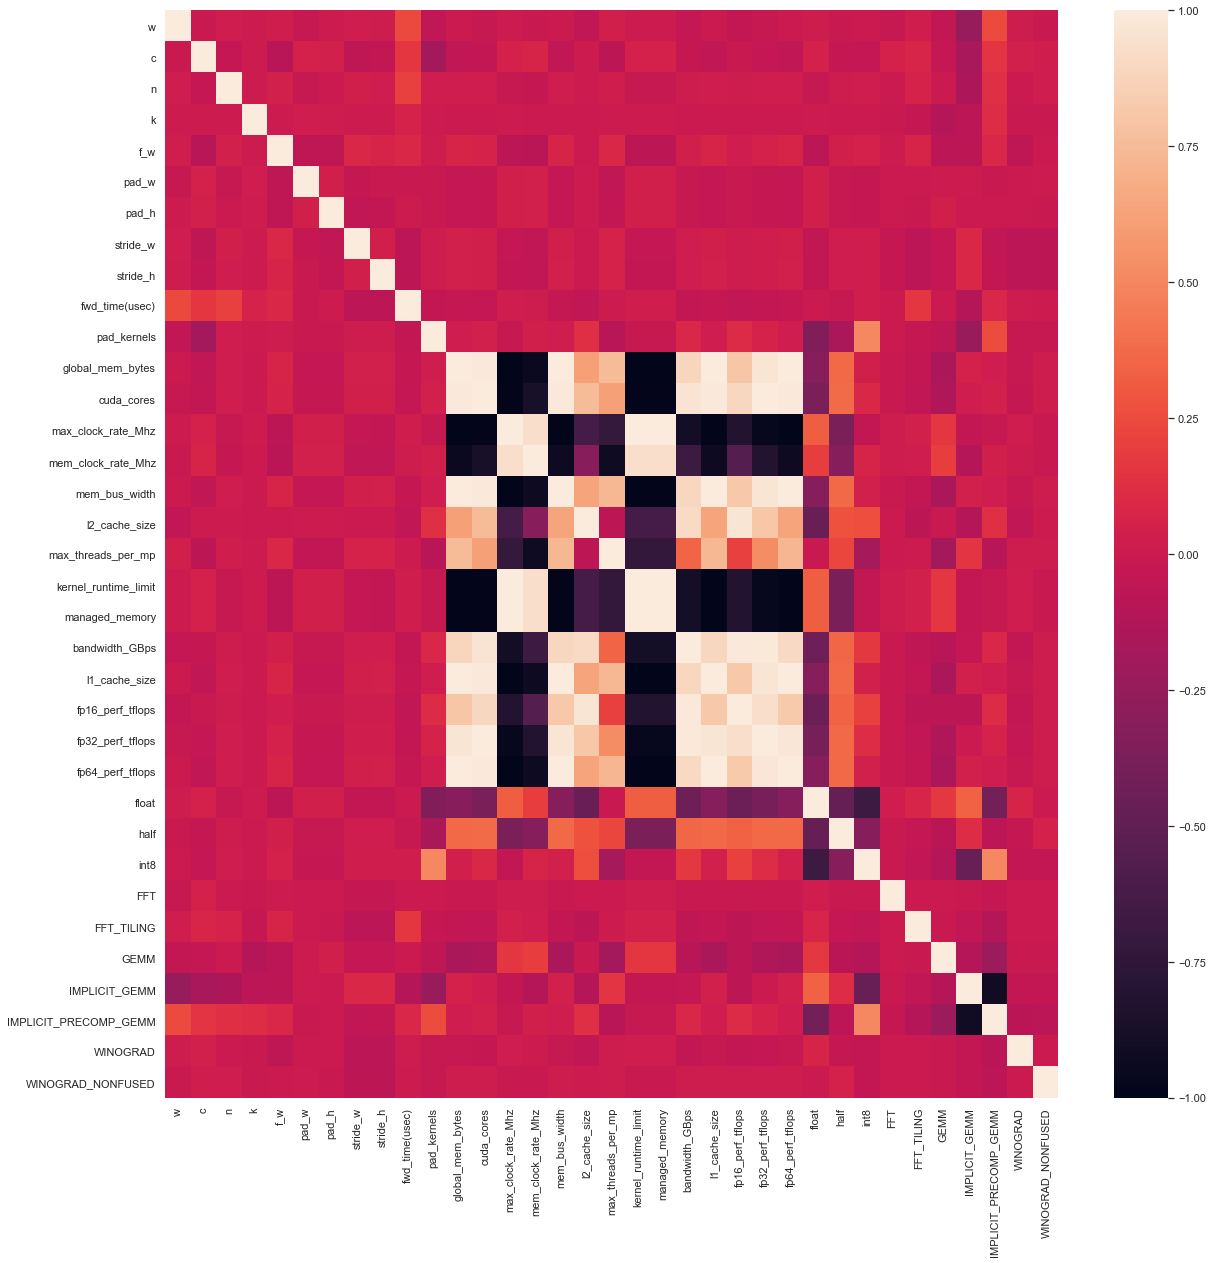

In [41]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [42]:
y = df['fwd_time(usec)']
X = df.drop(columns=['fwd_time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [11]:
clf = MLPRegressor(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.7778640735999148

In [12]:
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.18056240068975526

In [13]:
clf = Ridge()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.18056258257986613

In [14]:
clf = Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.11329567755548708

In [15]:
clf = SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4768860825568131

In [16]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5119200202627856

In [17]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.44152734338645394

In [43]:
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7999831484729392

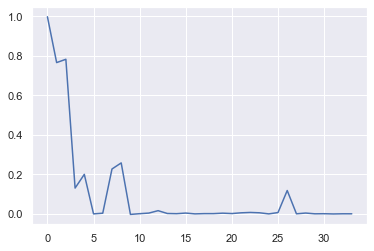

In [44]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(random_forest_result.importances_mean)

In [45]:
importances = pd.Series(random_forest_result.importances_mean).sort_values(ascending=False)
idx = importances.index

In [46]:
imp = []
for x, y in zip(df.columns[idx], importances.values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('w', 0.998157832517836),
 ('n', 0.7826422314293955),
 ('c', 0.7659672012517864),
 ('stride_h', 0.2577480037548094),
 ('stride_w', 0.2269100771557991),
 ('f_w', 0.1997415452266576),
 ('k', 0.13033346287638337),
 ('half', 0.11791800741605366),
 ('cuda_cores', 0.015827070077563444),
 ('fp16_perf_tflops', 0.00684184253038903),
 ('float', 0.006187122118768307),
 ('fp32_perf_tflops', 0.005054767279624317),
 ('l1_cache_size', 0.0049466771590927164),
 ('FFT', 0.0037706758144576136),
 ('mem_bus_width', 0.0036612613032477757),
 ('global_mem_bytes', 0.003621903238557733),
 ('managed_memory', 0.0031644814472222005),
 ('pad_h', 0.0030130190385787457),
 ('max_clock_rate_Mhz', 0.001611197833512401),
 ('bandwidth_GBps', 0.0012998521443921772),
 ('kernel_runtime_limit', 0.0009493438479492467),
 ('max_threads_per_mp', 0.0009133518740600977),
 ('mem_clock_rate_Mhz', 0.0006076775888460451),
 ('pad_kernels', 0.0005656163879326437),
 ('GEMM', 0.00040482121758855794),
 ('IMPLICIT_PRECOMP_GEMM', 4.493603227

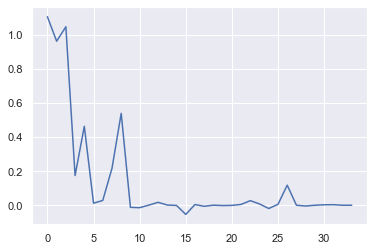

In [47]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(decision_tree_results.importances_mean)


In [48]:
importances = pd.Series(decision_tree_results.importances_mean).sort_values(ascending=False)
idx = importances.index

In [49]:
imp = []
for x, y in zip(df.columns[idx], importances.values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('w', 1.106913112010805),
 ('n', 1.0481240064632893),
 ('c', 0.9633502019432527),
 ('stride_h', 0.5393527628405412),
 ('f_w', 0.46354159915522),
 ('stride_w', 0.21648765015424365),
 ('k', 0.17449864813379756),
 ('half', 0.11767660267503861),
 ('pad_h', 0.028002880893784554),
 ('fp16_perf_tflops', 0.026902892024250204),
 ('cuda_cores', 0.01713091513701027),
 ('pad_w', 0.012099804323998497),
 ('fp32_perf_tflops', 0.007485826462776468),
 ('float', 0.005475437757863388),
 ('l1_cache_size', 0.0048458904103810705),
 ('l2_cache_size', 0.004103346704231558),
 ('IMPLICIT_GEMM', 0.0032392257044795538),
 ('GEMM', 0.002712504096575319),
 ('max_clock_rate_Mhz', 0.001163619155047535),
 ('global_mem_bytes', 0.0008195487531936996),
 ('kernel_runtime_limit', 0.00045574774708958545),
 ('IMPLICIT_PRECOMP_GEMM', 9.382301042040186e-05),
 ('WINOGRAD', 9.900028018039464e-07),
 ('int8', 5.645327982861659e-09),
 ('FFT_TILING', -5.874787094510836e-05),
 ('bandwidth_GBps', -0.0008146355455090459),
 ('mem_clock_

In [50]:
# BEGIN GEMM


In [51]:
df = load_csv(GEMM_FILE)
df = prune_columns_gemm(df)
df = one_hot_encode_gemm(df)
print(df.info())
print(df.describe())

Dropped columns:  <PandasArray>
[                'total_const_mem',      'total_shared_mem_per_block',
         'total_num_reg_per_block',                       'warp_size',
           'max_threads_per_block',                 'gpu_sharing_mem',
            'host_page_locked_mem',                     'ecc_support',
              'unified_addressing',              'compute_preemption',
       'cooperative_kernel_launch', 'multi_device_cooperative_kernel']
Length: 12, dtype: object ['sm_cap', 'cuda_version']
New encoded columns: Index(['float', 'half'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40965 entries, 0 to 40964
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   m                     40965 non-null  int64  
 1   n                     40965 non-null  int64  
 2   k                     40965 non-null  int64  
 3   a_t                   40965 non-null  int64  
 4   b_t    

array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'a_t'}>],
       [<AxesSubplot:title={'center':'b_t'}>,
        <AxesSubplot:title={'center':'time(usec)'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>,
        <AxesSubplot:title={'center':'cuda_cores'}>],
       [<AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>,
        <AxesSubplot:title={'center':'l2_cache_size'}>],
       [<AxesSubplot:title={'center':'max_threads_per_mp'}>,
        <AxesSubplot:title={'center':'bandwidth_GBps'}>,
        <AxesSubplot:title={'center':'l1_cache_size'}>,
        <AxesSubplot:title={'center':'fp16_perf_tflops'}>],
       [<AxesSubplot:title={'center':'fp32_perf_tflops'}>,
        <AxesSubplot:title={'center':'fp64_perf_tflops'}>,
        <AxesSubplot:t

<Figure size 432x288 with 0 Axes>

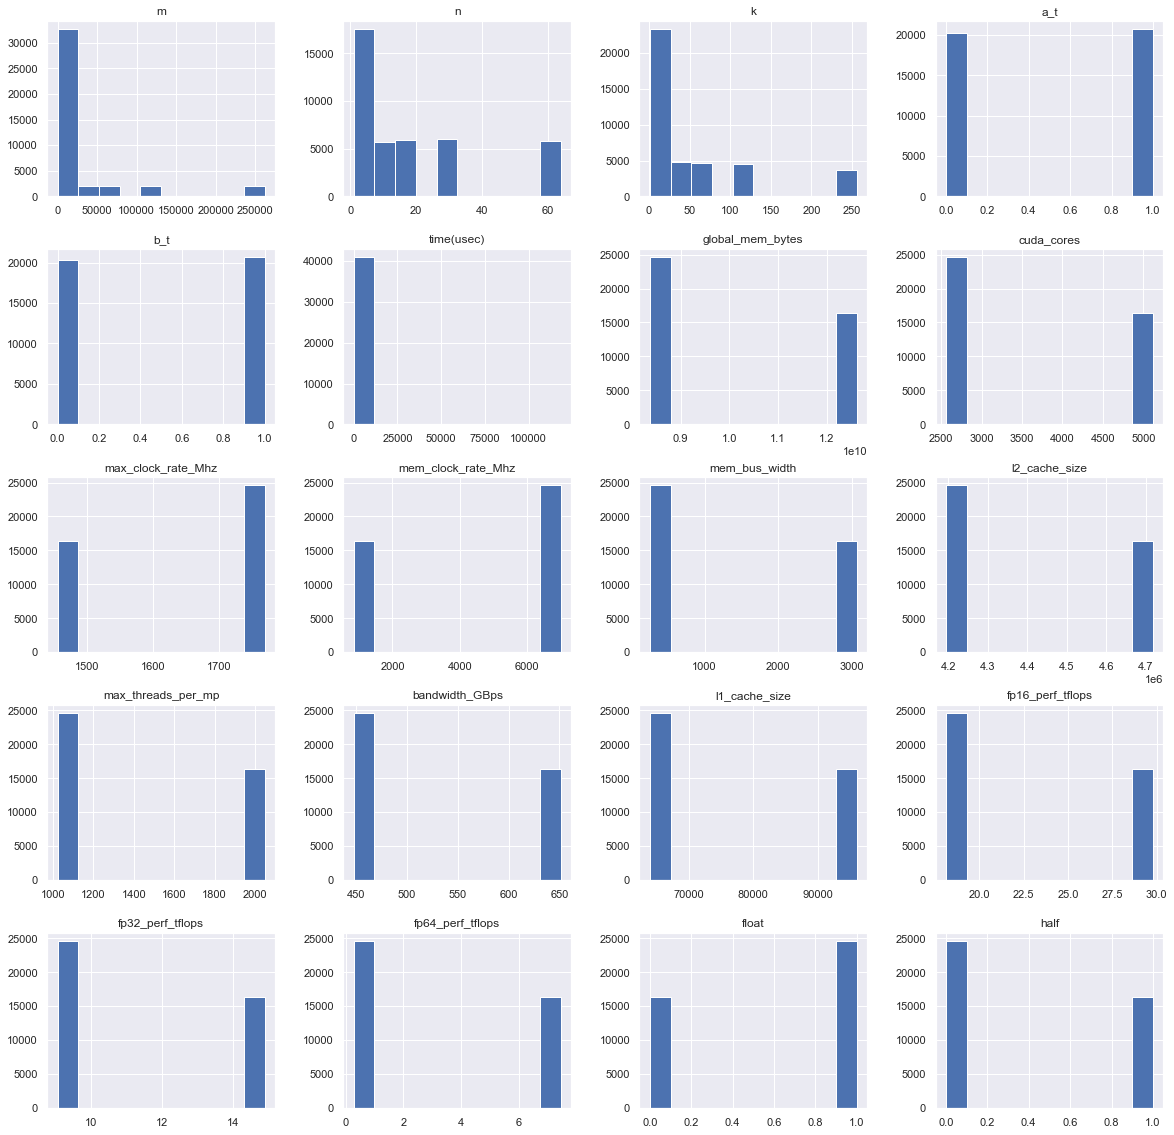

In [52]:
fig = plt.figure()
df.hist(figsize=(20,20))

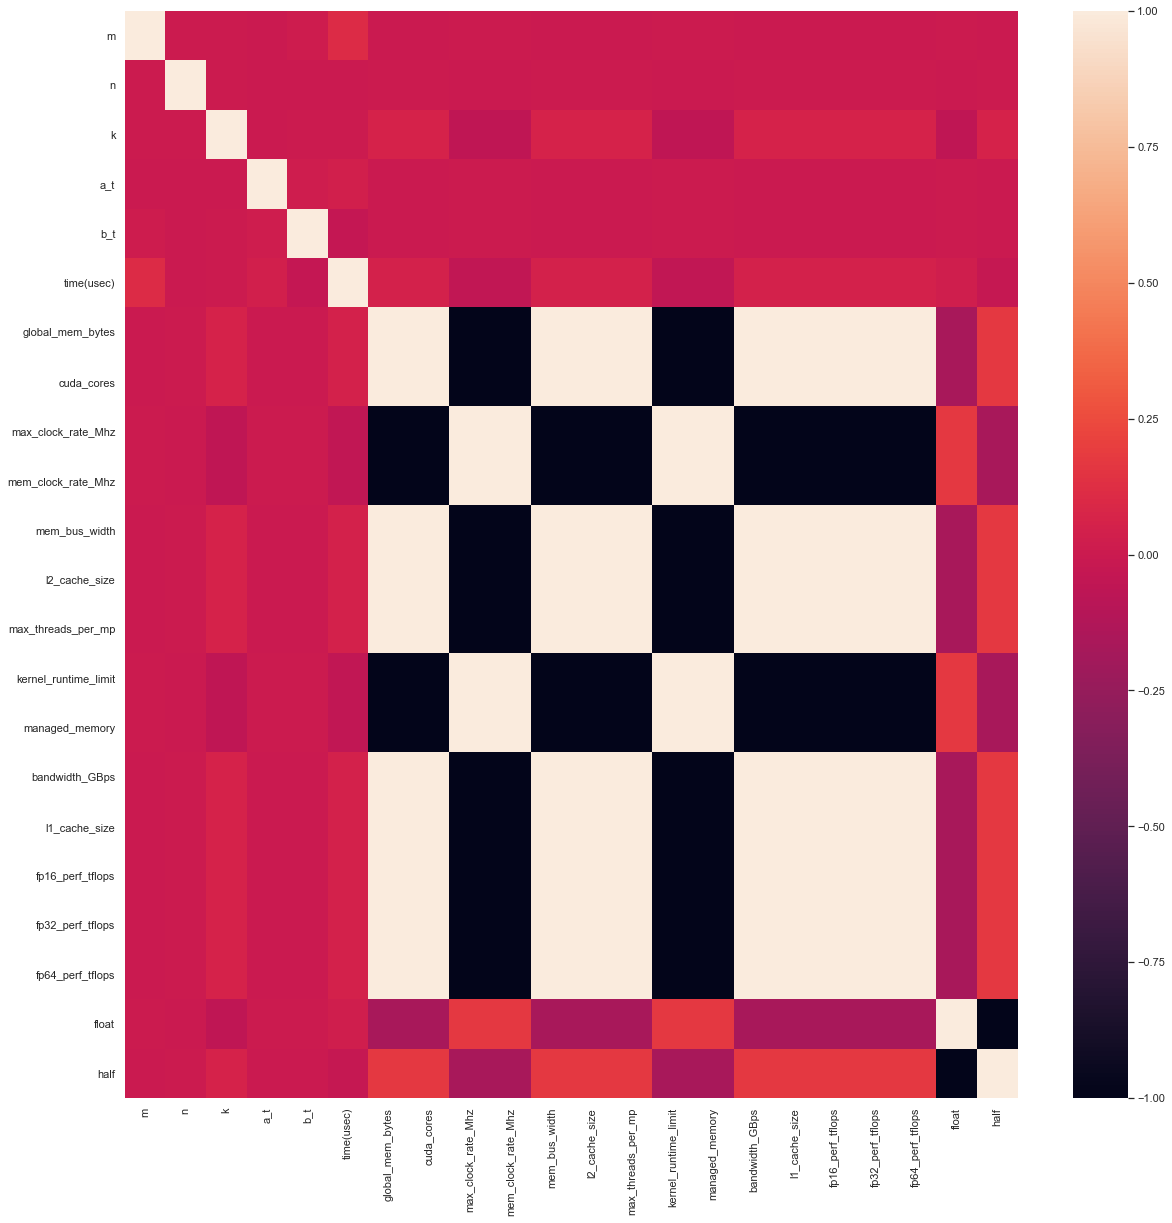

In [53]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [54]:
y = df['time(usec)']
X = df.drop(columns=['time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [55]:
clf = RandomForestRegressor(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9739260743561267

(array([15.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  1.]),
 array([1.23775834e-03, 2.08728457e-01, 4.16219155e-01, 6.23709854e-01,
        8.31200553e-01, 1.03869125e+00, 1.24618195e+00, 1.45367265e+00,
        1.66116335e+00, 1.86865405e+00, 2.07614474e+00]),
 <BarContainer object of 10 artists>)

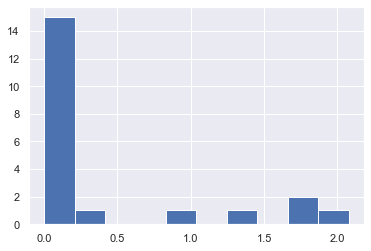

In [56]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.hist(random_forest_result.importances_mean)

In [57]:
importances = pd.Series(random_forest_result.importances_mean).sort_values(ascending=False)
idx = importances.index

In [58]:
imp = []
for x, y in zip(df.columns[idx], importances.values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('k', 2.0761447438559015),
 ('m', 1.7702118118012102),
 ('b_t', 1.6980559159871729),
 ('n', 1.422139654166675),
 ('a_t', 0.8750001664645062),
 ('fp64_perf_tflops', 0.271856897822874),
 ('float', 0.06439808978548972),
 ('max_clock_rate_Mhz', 0.016051164863695556),
 ('fp16_perf_tflops', 0.014817275220179282),
 ('max_threads_per_mp', 0.012677038127195183),
 ('l1_cache_size', 0.011645476412911382),
 ('cuda_cores', 0.010316494928146857),
 ('kernel_runtime_limit', 0.005471273400734078),
 ('bandwidth_GBps', 0.005231232495985128),
 ('mem_clock_rate_Mhz', 0.004723420382101606),
 ('l2_cache_size', 0.002707359388581754),
 ('global_mem_bytes', 0.002281944690006532),
 ('time(usec)', 0.0022606691793258136),
 ('managed_memory', 0.0018122963550709415),
 ('mem_bus_width', 0.0015924995481414682),
 ('fp32_perf_tflops', 0.0012377583384383327)]

In [59]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9483699627409916

(array([14.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  2.,  1.]),
 array([0.        , 0.21044021, 0.42088041, 0.63132062, 0.84176082,
        1.05220103, 1.26264123, 1.47308144, 1.68352164, 1.89396185,
        2.10440205]),
 <BarContainer object of 10 artists>)

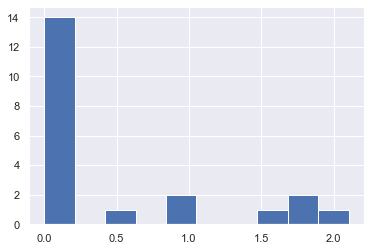

In [60]:
decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.hist(decision_tree_results.importances_mean)


In [61]:
importances = pd.Series(decision_tree_results.importances_mean).sort_values(ascending=False)
idx = importances.index

In [62]:
df.drop(columns=['time(usec)'], inplace=True)

imp = []
for x, y in zip(df.columns[idx], importances.values):
    imp.append((x, y))
print('Most "important" columns in dataset: ')
imp

Most "important" columns in dataset: 


[('k', 2.104402051551338),
 ('m', 1.848204885709238),
 ('b_t', 1.7904144521952259),
 ('n', 1.477528085337236),
 ('max_threads_per_mp', 0.9171599215469902),
 ('a_t', 0.9049759887215935),
 ('float', 0.5320102124596332),
 ('mem_clock_rate_Mhz', 0.126388443449821),
 ('half', 0.07989134135179342),
 ('global_mem_bytes', 0.0026144660395818866),
 ('mem_bus_width', 0.0),
 ('max_clock_rate_Mhz', 0.0),
 ('cuda_cores', 0.0),
 ('kernel_runtime_limit', 0.0),
 ('managed_memory', 0.0),
 ('bandwidth_GBps', 0.0),
 ('l1_cache_size', 0.0),
 ('fp16_perf_tflops', 0.0),
 ('fp32_perf_tflops', 0.0),
 ('fp64_perf_tflops', 0.0),
 ('l2_cache_size', 0.0)]

In [63]:
df.kernel_runtime_limit.value_counts()

True     24579
False    16386
Name: kernel_runtime_limit, dtype: int64